In [1]:
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import cv2

In [3]:
def load_and_prepare_image(image_path):
    image = Image.open(image_path)
    h, w = 0, 0
    
    if image.height > 480:
        h = 480
    else:
        h = image.height

    h = h - (h % 32)
    w = int(h * image.width / image.height)
    
    diff = w % 32
    if diff < 16:
        w = w - diff
    else:
        w + 32 - diff

    return image.resize((w, h))

In [4]:
def predict_depth(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs)
        return outputs.predicted_depth

In [5]:
def remove_borders(depth_map, image, pad = 16):
    depth_map = depth_map.squeeze().cpu().numpy() * 1000.0
    depth_map = depth_map[pad:-pad, pad:-pad]
    cropped_image = image.crop((pad, pad, image.width - pad, image.height - pad))
    
    return depth_map, cropped_image

In [6]:
def visualize_results(image, depth_map):
    fig, ax = plt.subplots(1, 2)

    ax[0].set_title("Original Image")
    ax[1].set_title("Depth Map")

    ax[0].imshow(image)
    ax[0].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    ax[1].imshow(depth_map, cmap = 'jet')
    ax[1].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    plt.tight_layout()

    plt.savefig("D://depth.png")  # Сохраняем изображение
    plt.close()  # Закрываем фигуру, чтобы не отображать её

    plt.pause(5)

In [7]:
def create_point_cloud(image, depth_map):
    depth_image = (depth_map * 255 / np.max(depth_map)).astype('uint8')
    image_array = np.array(image)
    
    depth_o3d = o3d.geometry.Image(depth_image)
    image_o3d = o3d.geometry.Image(image_array)
    image_RGBD = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity = False)
    
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsic.set_intrinsics(image.width, image.height, 500, 500, image.width * 0.5, image.height * 0.5)

    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(image_RGBD, camera_intrinsic)

    print(f"Количество точек: {len(point_cloud.points)}")
    
    cleaned_point_cloud, indexes = point_cloud.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 5)
    point_cloud = point_cloud.select_by_index(indexes)

    print(f"Количество точек после удаления выбросов: {len(point_cloud.points)}")
    
    point_cloud.estimate_normals()
    point_cloud.orient_normals_to_align_with_direction()
    
    return point_cloud

In [8]:
def reconstruct_surface(point_cloud):
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth = 10, n_threads = 8)[0]
    rotation = mesh.get_rotation_matrix_from_xyz((3.14159, 0, 0))
    mesh.rotate(rotation, center = (0, 0, 0))
    return mesh

In [9]:
def save_and_visualize_mesh(mesh, point_cloud, output_path):
    o3d.io.write_triangle_mesh(output_path, mesh)
    o3d.visualization.draw_geometries([point_cloud])

## Визуализация облака точек + 3D модель

In [13]:
image = load_and_prepare_image("F://42.jpg")
    
#  Инициализация модели для оценки глубины и экстрактора для подготавки изображения
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")
x_inputs =  feature_extractor(images = image, return_tensors="pt")
predicted_depth = predict_depth(model, x_inputs)
    
depth_map, cropped_image = remove_borders(predicted_depth, image)
visualize_results(cropped_image, depth_map)

### ## Визуализация облака точек + 3D модель

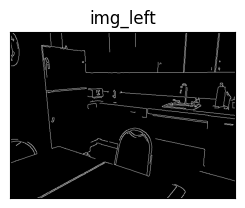

In [19]:
# Контур
cropped_image_np = np.array(cropped_image)

if len(cropped_image_np.shape) == 3 and cropped_image_np.shape[2] == 3:
    cropped_image_gray = cv2.cvtColor(cropped_image_np, cv2.COLOR_RGB2GRAY)
else:
    cropped_image_gray = cropped_image_np

image_cropped_cv = cropped_image_gray
cv2.imwrite('D://output_image.jpg', image_cropped_cv)

conture = cv2.Canny(image_cropped_cv, 100, 200)
len(conture)

def plot(title_str, image, index):
    plt.subplot(2, 2, index)
    plt.title(title_str)
    plt.imshow(image, 'gray')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

plot('img_left', conture, 1)

In [ ]:
def apply_contour_mask(depth_map, image, contour_mask):
    """
    Применяет маску контура к depth_map и изображению.
    """
    # Применяем маску к depth_map
    depth_map_masked = np.where(contour_mask == 255, depth_map, 0)  # Оставляем только значения на контуре
    
    # Применяем маску к изображению
    image_array = np.array(image)
    image_masked = np.zeros_like(image_array)  # Создаем пустое изображение
    image_masked[contour_mask == 255] = image_array[contour_mask == 255]  # Копируем только пиксели на контуре
    
    # Преобразуем обратно в PIL Image
    image_masked_pil = Image.fromarray(image_masked)
    
    return depth_map_masked, image_masked_pil

# Применяем маску контура к depth_map и cropped_image
depth_map_masked, image_masked = apply_contour_mask(depth_map, cropped_image, conture)

In [ ]:
point_cloud = create_point_cloud(image_masked, depth_map_masked)

In [ ]:
mesh = reconstruct_surface(point_cloud)
save_and_visualize_mesh(mesh, point_cloud, 'D://mesh0304_1.obj')